# Run the evaluation models

In [1]:
!pip install xgboost
!pip install plydata

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/hpf/tools/centos6/python/3.7.1/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/hpf/tools/centos6/python/3.7.1/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import pickle
from joblib import dump, load
import numpy as np
import pandas as pd
from time import time
from scipy.interpolate import UnivariateSpline
from support.acc_funs import fast_auc, fast_decomp, write_fast_decomp, write_fast_inference, gen_CI
import plotnine
from plotnine import *
from plydata.cat_tools import *

# Set directories
dir_base = os.getcwd()
dir_NSQIP = os.path.join(dir_base,'..')
dir_output = os.path.join(dir_NSQIP, 'output')
dir_models = os.path.join(dir_output, 'models')

# cpt_trans = cpt_desciptions()

di_outcome = {'adv':'ADV', 'aki':'AKI', 'cns':'CNS',
              'nsi':'nSSIs', 'ssi':'SSIs', 'unplan':'UPLN'}
di_rev_outcome = {k: v for v, k in di_outcome.items()}
di_metric = {'ppv':'PPV','sens':'Sensitivity'}
di_tt = {'total':'Total', 'within':'Within', 'between':'Between'}

def cvec(x):
    return np.atleast_2d(x).T

### (1) Load data

In [55]:
# (i) Load in the "best" model/label order
best_mdl = pd.read_csv(os.path.join(dir_output, 'best_mdl.csv'))

# (ii) Load the AUROC variance
dat_var = pd.read_csv(os.path.join(dir_output, 'dat_var.csv'))
spl = UnivariateSpline(x=dat_var.auc, y=dat_var.c)

cn_gg = ['model','outcome','version','method']
# (iii) Load the AUROC point estimates and uncertainty for 
df_within = pd.read_csv(os.path.join(dir_output, 'df_within.csv'))
df_within_inf = pd.read_csv(os.path.join(dir_output, 'df_within_inf.csv'))
df_within = df_within.query('tt!="between" & method=="agg"').reset_index(None,True)
df_within = df_within.assign(n0 = lambda x: np.where(x.tt=="total", (x.den/x.n1),0).astype(int))
df_within = df_within.assign(se=lambda x: np.sqrt((x.n1+x.n0+1)/spl(x.auc)/(x.n1*x.n0)))
tmp = df_within_inf.groupby(cn_gg).auc.std(ddof=1).reset_index().rename(columns={'auc':'se2'}).assign(tt='within')
df_within = df_within.merge(best_mdl,'inner',cn_gg).merge(tmp,'left')
df_within = df_within.assign(se=lambda x: np.where(x.se2.isnull(), x.se, x.se2)).drop(columns='se2')
df_within = pd.concat([df_within, gen_CI(x=df_within.auc.values, se=df_within.se.values, alpha=0.05)],1)
df_within_cpt = pd.read_csv(os.path.join(dir_output, 'df_within_cpt.csv'))
df_within_cpt = df_within_cpt.query('method=="agg"').reset_index(None, True)
df_within_cpt = df_within_cpt.merge(best_mdl)

# (iv) Load in the existing X data
df_X = pd.read_csv(os.path.join(dir_output,'X_imputed.csv'))

# (v) Load in the SK data
val_Y = pd.read_csv(os.path.join(dir_output,'val_Y.csv'))
val_Yagg = pd.read_csv(os.path.join(dir_output,'val_Yagg.csv'))
# Give the aggregate labels a versio
val_Yagg.rename(columns={'aki':'aki1', 'cns':'cns1'}, inplace=True)
# Give a year to the Xdata
dat_Xmap = pd.read_csv(os.path.join(dir_output,'dat_Xmap.csv')).assign(operyr=val_Y.operyr.values)
assert all(val_Y.caseid == dat_Xmap.caseid)
assert all(val_Y.caseid == val_Yagg.caseid)
# Make sure the columns match the same order
dat_Xmap = dat_Xmap[df_X.columns]

# (vi) Format data into X format
#      Use pd.get_dummes() from existing df_X to make sure format is the same
dat_X = pd.get_dummies(pd.concat([df_X, dat_Xmap],0))
# dat_X = pd.get_dummies(df_X)
dat_X['cpt'] = 'c' + dat_X.cpt.astype(str)
cn_X = list(dat_X.columns[2:])
assert dat_X[cn_X].shape[1] == 109
# Subset to our participants
dat_X_Xmap = dat_X.iloc[df_X.shape[0]:]
assert all(dat_X_Xmap.caseid == dat_Xmap.caseid)

# Make a copy of the CPTs and then remove
Xtest_SK = dat_X_Xmap[cn_X]
cpt_SK = Xtest_SK.cpt.values
del Xtest_SK['cpt']

# (vii) Get the ycount
dat_ycount = val_Yagg.melt(['caseid','operyr'],None,'outcome','n').groupby('outcome').n.sum().reset_index()
dat_ycount = dat_ycount.assign(version=lambda x: x.outcome.str.replace('[a-z]','').replace('','1').astype(int),
                  outcome=lambda x: x.outcome.str.replace('[0-9]',''))
dat_ycount = dat_ycount.merge(best_mdl,'inner',['outcome','version']).assign(outcome=lambda x: x.outcome.map(di_outcome))
# dat_ycount = dat_ycount.assign(outcome = lambda x: cat_reorder(x.outcome, x.n))

# (viii) Load the Precision/Recall tradeoff and thresholds
res_ppv = pd.read_csv(os.path.join(dir_output, 'res_ppv.csv'))
dat_pp_qq = res_ppv.groupby(['outcome','pp']).qq.mean().reset_index()
dat_pp_qq.outcome = dat_pp_qq.outcome.map(di_rev_outcome)

### (2) Check for duplicates

In [66]:
cn_drop = ['caseid','operyr']
# (i) Within the validation set we have one perfect duplicates
dup_test = dat_Xmap[dat_Xmap.drop(columns=cn_drop).duplicated(keep=False)].T.reset_index()
dup_test.rename(columns={'index':'column_name',110:'patient1', 111:'patient2'}, inplace=True)
dup_test.to_csv(os.path.join(dir_output,'dup_test.csv'),index=False)
ndup_test = int(dup_test.shape[1]/2)
print('There are a total of %i duplicate pairs in the test set' % ndup_test)
# (ii) Check for duplicates in training
ndup_train = int(df_X[df_X.drop(columns=cn_drop).duplicated(keep=False)].shape[0]/2)
print('There are a total of %i duplicate pairs in the training set' % ndup_train)

There are a total of 1 duplicate pairs in the test set
There are a total of 60 duplicate pairs in the training set


In [106]:
# Find the numerical vs categorical columns
Xdtypes = dat_Xmap.dtypes.drop(cn_drop)
cn_cat = Xdtypes[Xdtypes==object].index.to_list()
cn_num = Xdtypes[Xdtypes!=object].index.to_list()
val_cat = df_X[cn_cat].values
val_num = df_X[cn_num].values

In [174]:
if 'dat_matcher.csv' in os.listdir(dir_output):
    dat_matcher = pd.read_csv(os.path.join(dir_output,'dat_matcher.csv'))
else:
    n_test = dat_Xmap.shape[0]
    stime = time()
    holder = []
    for ii in range(n_test):
        if (ii + 1) % 10 == 0:
            nleft, nsec = n_test - (ii+1), time() - stime
            rate = (ii+1) / nsec
            eta = nleft / rate
            print('Iteration %i, ETA: %i seconds' % (ii+1, eta))
        prop_cat = (val_cat == dat_Xmap.iloc[[ii]][cn_cat].sample(n=df_X.shape[0],replace=True).values).mean(1)
        err_num = np.sum(np.abs(val_num - dat_Xmap.iloc[[ii]][cn_num].sample(n=df_X.shape[0],replace=True).values),1)
        idx_min = np.argmin(err_num)
        tmp_df = pd.DataFrame({'idx':ii,'caseid':df_X.caseid[idx_min],'err':err_num[idx_min],'prop':prop_cat[idx_min]},index=[0])
        holder.append(tmp_df)
    dat_matcher = pd.concat(holder).reset_index(None,True)
    dat_matcher.to_csv(os.path.join(dir_output,'dat_matcher.csv'),index=False)
# Subset to most possible duplicates
dat_possib = dat_matcher.query('prop>0.95').sort_values('err').query('err < 2').rename(columns={'caseid':'caseid_nsqip'})
dat_possib['idx'] = dat_Xmap.caseid[dat_possib.idx.values].values
dat_possib = dat_possib.rename(columns={'idx':'caseid_SK'}).reset_index(None,True)
holder = []
for ii, rr in dat_possib.iterrows():
    caseid_SK = int(rr['caseid_SK'])
    caseid_nsqip = int(rr['caseid_nsqip'])
    tmp_slice = pd.concat([df_X.query('caseid==@caseid_nsqip'),
                           dat_Xmap.query('caseid==@caseid_SK')])[cn_drop + cn_num + cn_cat].T
    tmp_cn = pd.MultiIndex.from_product([['patient_'+str(ii+1)],['NSQIP','SK']])
    tmp_slice.columns = tmp_cn
    holder.append(tmp_slice)
dat_suspect = pd.concat(holder,1)
dat_suspect.to_csv(os.path.join(dir_output,'dat_suspect.csv'))

In [4]:
# # We have actually have one duplicated patient from 2019!
# cn_sanity = ['age_days', 'htooday', 'height', 'weight']
# holder = []
# for ii in range(len(dat_X_Xmap)):
#     cid = dat_X_Xmap.loc[ii,'caseid']
#     dd = np.sum(np.abs(dat_X_Xmap[cn_sanity].loc[[ii]].values - dat_X[cn_sanity].values),1)
#     didx = pd.DataFrame({'didx':dd}).sort_values('didx').rename_axis('idx').reset_index().head()
#     didx = pd.concat([didx,dat_X[['caseid','operyr','cpt']].iloc[didx.idx.values].reset_index(None,True)],1)
#     didx = didx.query('didx==0 | operyr < 2019').head(2).assign(ii=ii)
#     if didx.shape[0] == 2:
#         holder.append(didx)
# #     ncpt = dat_X.iloc[didx].cpt.unique().shape[0]
# #     if ncpt == 1:
# #         print('Found one!')
# #         tmp_df = dat_X.iloc[didx].reset_index(None,True).assign(tt=['SK','NSQIP'])
# #         holder.append(tmp_df)
# dat_sanity = pd.concat(holder).reset_index().rename(columns={'idx':'ridx','index':'idx'})
# dat_sanity.to_csv(os.path.join(dir_output,'dat_sanity.csv'),index=False)

In [5]:
# dat_sanity = pd.concat(holder).reset_index()
# dat_sanity.insert(0,'pair',dat_sanity.groupby(['index']).cumcount())
# dat_sanity = dat_sanity.drop(columns=cn_sanity+['cpt']).melt(['pair','index','caseid','operyr','tt'],None,'cn')
# tmp_sanity = dat_sanity.query('index == 1')[['pair','operyr']].assign(check =lambda x: x.operyr<=2018).drop(columns = 'operyr')
# dat_sanity = dat_sanity.merge(tmp_sanity,'left','pair')
# dat_sanity_w = dat_sanity.pivot_table('value',['check','pair','cn'],'tt').reset_index()
# dat_sanity_n = dat_sanity_w.groupby(['check','pair']).apply(lambda x: np.sum(x.NSQIP != x.SK)).reset_index()
# dat_sanity_n.rename(columns={0:'n'}, inplace=True)
# # (ggplot(dat_sanity, aes(x='n')) + geom_histogram() + theme_bw())
# # dat_sanity_w
# n2_pairs = dat_sanity_n.query('check==True').query('n==2').pair.values

### (3) Load the models

In [6]:
import warnings
warnings.filterwarnings("ignore")

fn_models = pd.Series(os.listdir(dir_models))
dat_models = pd.DataFrame({'model':fn_models.str.split('\\_',1,True).iloc[:,0],
                           'outcome':fn_models.str.split('agg\\_|\\.sav',3,True).iloc[:,2]})
dat_models = dat_models.assign(version=lambda x: x.outcome.str.replace('[a-z]','').replace('','1').astype(int),
                               fn=fn_models, outcome=lambda x: x.outcome.str.replace('[0-9]',''))
dat_models = dat_models.merge(best_mdl, 'inner', ['model','outcome','version'])

holder = []
for ii, rr in dat_models.iterrows():
    outcome, version, model, fn = rr['outcome'], rr['version'], rr['model'], rr['fn']
    #print('outcome: %s, version: %s, model: %s' % (outcome, version, model))
    clf = load(os.path.join(dir_models,fn))
    yn = outcome+str(version)
    yval = val_Yagg[yn].values
    if yval.sum() == 0:
        print('Skipping, y==0')
        continue
    tmp_df = pd.DataFrame({'caseid':dat_X_Xmap.caseid.values,
                            'outcome':outcome, 'y':yval,
                            'preds':clf.predict_proba(Xtest_SK)[:,1]})
    holder.append(tmp_df)
dat_preds = pd.concat(holder).reset_index(None,True)
dat_preds = dat_X_Xmap[['caseid','cpt']].merge(dat_preds,'right','caseid')

Skipping, y==0


### (4) Run the inference

In [7]:
# Run the decomposition
cn_within = ['outcome']
fn_within_sk = 'fn_within_sk.csv'
df_within_sk = write_fast_decomp(df=dat_preds, fn=fn_within_sk, cn=cn_within, path=dir_output, ret_df=False)
fn_within_sk_cpt = 'df_within_sk_cpt.csv'
df_within_sk_cpt = write_fast_decomp(df=dat_preds, fn=fn_within_sk_cpt, cn=cn_within, path=dir_output, ret_df=True)

# Do the stratified boostrap for inference
fn_within_sk_inf = 'df_within_sk_inf.csv'

if fn_within_sk_inf in os.listdir(dir_output):
    print('Loading existing file: %s' % fn_within_sk_inf)
    dat_bs = pd.read_csv(os.path.join(dir_output, fn_within_sk_inf))
else:
    n_bs = 1000
    holder_bs = []
    stime = time()
    for ii in range(n_bs):
        tmp_gb = dat_preds.groupby(['outcome','y']).sample(frac=1,replace=True,random_state=ii).groupby('outcome')
        tmp_gb = tmp_gb.apply(lambda x: fast_decomp(x.y, x.preds, x.cpt)).reset_index().assign(idx=ii)
        holder_bs.append(tmp_gb)
        nleft, nsec = n_bs - (ii+1), time() - stime
        rate = (ii+1) / nsec
        eta = nleft / rate
        if (ii+1) % 50 == 0:
            print('Iteration %i, ETA: %i seconds' % (ii, eta))
    dat_bs = pd.concat(holder_bs).reset_index(None,True).drop(columns='level_1')
    dat_bs.to_csv(os.path.join(dir_output, fn_within_sk_inf),index=False)

alpha = 0.05
pvals = [alpha/2, 1-alpha/2]
cn_bs = ['outcome','tt']
dat_bs_ci = dat_bs.groupby(cn_bs).auc.quantile(pvals).reset_index().pivot_table('auc',cn_bs,'level_2')
dat_bs_ci = dat_bs_ci.rename(columns=dict(zip(pvals, ['lb', 'ub']))).reset_index()
df_within_sk = df_within_sk.merge(dat_bs_ci.query('tt!="between"'), 'inner', cn_bs)

Decomposition already exists, loading: fn_within_sk.csv
Decomposition already exists, loading: df_within_sk_cpt.csv
Loading existing file: df_within_sk_inf.csv


In [8]:
# Calculate the precision/recall
cn_qq = ['outcome','pp','y']
res_qq = dat_preds.merge(dat_pp_qq,'left','outcome').assign(ypred = lambda x: np.where(x.preds >= x.qq, 1, 0))
res_qq = res_qq.groupby(cn_qq+['ypred']).size().reset_index().pivot_table(0,cn_qq,'ypred').fillna(0).astype(int)
res_qq = res_qq.reset_index().melt(cn_qq,None,None,'n')
res_qq = res_qq.sort_values(['outcome','pp','y','ypred']).reset_index(None,True)
# Calculate the precision
res_ppv_sk = res_qq.query('ypred==1').groupby(['outcome','pp']).apply(lambda x: x.n.values[1] / x.n.sum()).reset_index()
res_ppv_sk = res_ppv_sk.rename(columns={0:'ppv'}).assign(ppv=lambda x: np.where(x.ppv==0,np.NaN, x.ppv))
# Calculate the recall
res_sens_sk = res_qq.query('y == 1').groupby(['outcome','pp']).apply(lambda x: x.n.values[1] / x.n.sum()).reset_index()
res_sens_sk = res_sens_sk.rename(columns={0:'sens'})
res_ppv_sk = res_ppv_sk.merge(res_sens_sk).melt(['outcome','pp'],None,'metric')
res_ppv_sk.outcome = res_ppv_sk.outcome.map(di_outcome)
# Join with NSQIP results
res_ppv_both = pd.concat([res_ppv_sk.assign(ds='SK'), res_ppv.assign(ds='NSQIP').drop(columns='qq')])

### (5) Compare to NSQIP

In [9]:
cn_within = ['outcome','tt','auc','lb','ub']
df_comp_within = pd.concat([df_within_sk[cn_within].assign(ds='SK'),
                            df_within[cn_within].assign(ds='NSQIP')]).reset_index(None, True)
df_comp_within = df_comp_within.assign(outcome=lambda x: x.outcome.map(di_outcome),
                                       tt=lambda x: x.tt.str.capitalize())
# Line up the available within-CPT AUROCs
cn_cpt = ['outcome','g','auc']
dat_cpt_comp = df_within_sk_cpt[cn_cpt].query('auc>=0').merge(df_within_cpt[cn_cpt],'inner',['outcome','g'])

### (6) Figures

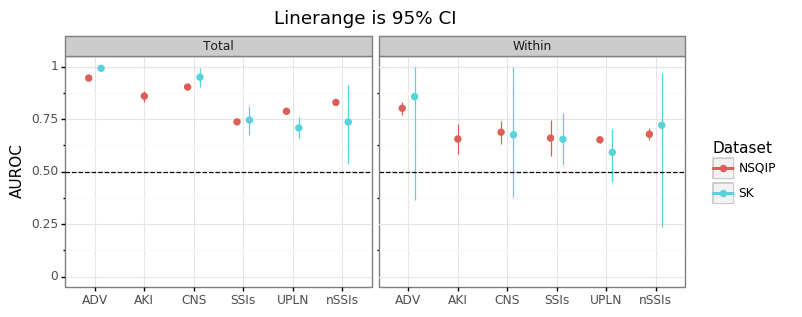

<ggplot: (2954734732629)>

In [10]:
posd = position_dodge(0.5)
plotnine.options.figure_size = (8, 3)
gg_comp_within = (ggplot(df_comp_within, aes(x='outcome', y='auc', color='ds')) + 
                  theme_bw() + geom_point(size=2, position=posd) + 
                  geom_linerange(aes(ymin='lb', ymax='ub'),position=posd) + 
                  labs(y='AUROC') + facet_wrap('~tt') + 
                  ggtitle('Linerange is 95% CI') + 
                  scale_y_continuous(limits=[0,1],breaks=list(np.arange(0,1.1,0.25))) + 
                  theme(axis_title_x=element_blank()) + 
                  scale_color_discrete(name='Dataset') + 
                  geom_hline(yintercept=0.5,linetype='--'))
gg_comp_within

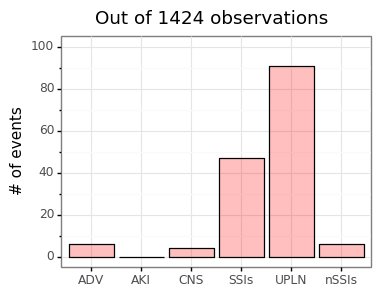

<ggplot: (2954738182383)>

In [11]:
plotnine.options.figure_size = (4, 3)
gg_ycount = (ggplot(dat_ycount, aes(x='outcome', y='n')) + theme_bw() + 
             geom_bar(stat='identity',color='black',fill='red',alpha=0.25) + 
             labs(y='# of events') + scale_y_continuous(limits=[0,100],breaks=list(range(0,101,20))) + 
             ggtitle('Out of %i observations' % val_Y.shape[0]) + 
             theme(axis_title_x=element_blank()))
gg_ycount

In [175]:
dat_ycount

,outcome,n,version,method,model
0,ADV,6,1,agg,rf
1,AKI,0,1,agg,logit
2,CNS,4,1,agg,logit
3,nSSIs,6,4,agg,rf
4,SSIs,47,1,agg,xgb
5,UPLN,91,2,agg,rf


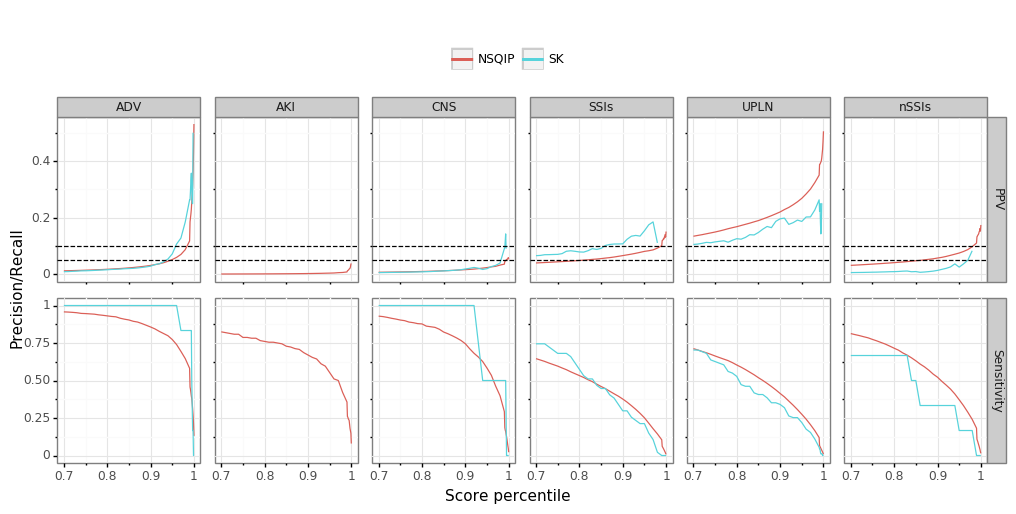

<ggplot: (-9223369082120078455)>

In [12]:
w, h = 12, 4.5
plotnine.options.figure_size = (w, h)
tmp = pd.DataFrame({'yi':[0.05,0.10],'metric':'ppv'})

gg_ppv = (ggplot(res_ppv_both, aes(x='pp',y='value',color='ds')) + 
          theme_bw() + geom_line() + 
          labs(x='Score percentile',y='Precision/Recall') + 
          scale_color_discrete(name=' ') + 
          scale_x_continuous(breaks=list(np.arange(0.7,1.01,0.10))) + 
          facet_grid('metric~outcome',scales='free_y', labeller=labeller(metric=di_metric)) + 
          theme(subplots_adjust={'wspace':0.10, 'hspace':0.1}, legend_position='top') + 
          geom_hline(aes(yintercept='yi'),linetype='--',data=tmp))
gg_ppv


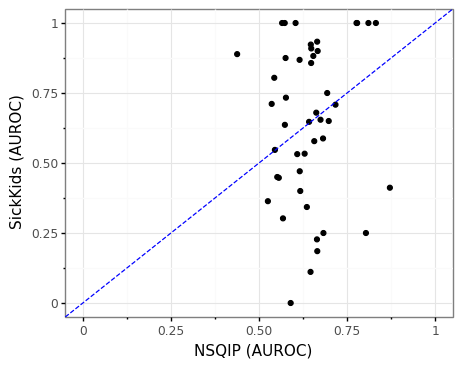

<ggplot: (2954741258339)>

In [13]:
w, h = 5, 4
plotnine.options.figure_size = (w, h)

gg_cpt_comp = (ggplot(dat_cpt_comp, aes(x='auc_y', y='auc_x')) + theme_bw() + 
               geom_point() + geom_abline(slope=1,intercept=0,color='blue',linetype='--') + 
               labs(y='SickKids (AUROC)', x='NSQIP (AUROC)') + 
               scale_y_continuous(limits=[0,1]) + scale_x_continuous(limits=[0,1]))
gg_cpt_comp
